In [1]:
# Importo las librerías Necesarias 
import numpy as np # Importo algebra Lineal
import matplotlib.pyplot as plt # Importo librería de gráficos
import math
import gmsh #Importo gmsh
import mef

# Problema 2

Determine la deformación y los esfuerzos principales en función de la posición para una chapa con
un agujero en el centro sujeta a tracción por sus extremos, como se muestra en la figura. Las
dimensiones de la chapa son de $ 20 x 10  in $ y su espesor de $ 1  in $. El radio del agujero
central es también de $ 1  in $. Tome $ E = 30 x 10^6  psi $ y $ v = 0.30 $.

Analice el problema con número creciente de elementos y estudie su convergencia.
 
<center><img src="Ej 2.png"></center>

### Desarrollo

#### Armo el modelo

In [2]:
gmsh.initialize() # Inicio el gmsh

In [3]:
gmsh.model.add('Ej 2') # Nombro el modelo

In [4]:
#Datos

L = 20 #in
lc = 0.3 #Densidad de triangulos en el modelo
h = 10 #in
t = 1 #in
r = 1 #in
E = 30E6 #psi
v = 0.3 #Coef de Poisson
T = 1000 #psi

#Grados de libertad
glxn = 2

In [5]:
# Definimos las coordenadas de los puntos
pc = gmsh.model.geo.addPoint(  0,   0, 0,    lc)
p1 = gmsh.model.geo.addPoint(  0,   r, 0, lc/15)
p2 = gmsh.model.geo.addPoint(  0, h/2, 0,    lc) 
p3 = gmsh.model.geo.addPoint(L/2, h/2, 0,    lc)
p4 = gmsh.model.geo.addPoint(L/2,   0, 0,    lc)
p5 = gmsh.model.geo.addPoint(  r,   0, 0, lc/15)

In [6]:
# Definimos las lineas
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p5)
ca1 = gmsh.model.geo.addCircleArc(p5, pc, p1)

In [7]:
# Las curvas nos van a servir para definir los bordes de nuestro modelo
C1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4, ca1])

# y la superficie
S1 = gmsh.model.geo.addPlaneSurface([C1])

In [8]:
gmsh.model.geo.synchronize()

In [9]:
# Definimos algo que nos va a servir para las condiciones de contorno.
Empotrado_V = gmsh.model.addPhysicalGroup(1, [l1]) # El 1 indica una dimensión
gmsh.model.setPhysicalName(1,Empotrado_V,'Empotrado_V')

Empotrado_H = gmsh.model.addPhysicalGroup(1, [l4]) # El 1 indica una dimensión
gmsh.model.setPhysicalName(1,Empotrado_H,'Empotrado_H')

Traccionado = gmsh.model.addPhysicalGroup(1, [l3])
gmsh.model.setPhysicalName(1,Traccionado,'Traccionado')

Superficie = gmsh.model.addPhysicalGroup(2,[S1]) # El 2 indica dos dimensiones
gmsh.model.setPhysicalName(2,Superficie, 'Superficie')

In [10]:
# Generamos el mallado
gmsh.model.mesh.generate(2) # el 2 indica la dimensión

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Circle)
Info    : Done meshing 1D (Wall 0.0070109s, CPU 0.008301s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0664979s, CPU 0.133197s)
Info    : 3156 nodes 6314 elements


In [11]:
# Vista del mallado
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.10.5
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20220701
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.4.0
PETSc version : 3.14.4 (real arithmtic)
OCC version   : 7.6.1
MED version   : 4.1.0
Packaged by   : geuzaine
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


#### Selección de datos y Armado de matrices

In [12]:
# Obtengo información sobre los nodos del mallado

NodeInfo = gmsh.model.mesh.get_nodes() # Información de los nodos
n_nodos = NodeInfo[0].shape[0] # Cantidad de nodos
MN = NodeInfo[1].reshape(n_nodos, 3) # Matriz de nodos (con eje Z)

#corro la primer fila al ultimo lugar, para evitar problemas al considerarlo un nodo
aux = MN[0,:]
MN = np.append(MN[1:,:],[aux],0)
#print(MN)

In [13]:
# Obtengo información sobre los elementos del mallado

E_etiq, Elementos = gmsh.model.mesh.get_elements_by_type(2) #El 2 es por elementos del tipo 2 (superficiales)
n_element = E_etiq.shape[0] # Cantidad de elementos
n_nxe = 3 #Número de nodos por elemento
MC = Elementos.reshape(n_element, n_nxe) # Matriz de conectividad
MC = MC - np.ones([n_element,n_nxe]) # Resto 1 para acomodar a lenguaje PYTHON.
MC = MC.astype(int) # Los cambio a dato tipo integer
#MC.shape[0]

In [14]:
#Armo la matriz D (igual para todos los elementos)

D = E/(1-v**2)*np.array([[1,  v,         0],
                         [v,  1,         0],
                         [0,  0, 0.5*(1-v)]])

In [15]:
#Armo la matriz B, A y Ke

alpha = np.zeros([n_nxe, n_element])
betha = np.zeros([n_nxe, n_element])
gamma = np.zeros([n_nxe, n_element])
B = {}
A = np.zeros(n_element)
Ke= {}
for i in range(n_element):
    nodos = MC[i, :]
    alpha[0, i] = MN[nodos[1],0]*MN[nodos[2],1]-MN[nodos[2],0]*MN[nodos[1],1]
    alpha[1, i] = MN[nodos[0],0]*MN[nodos[2],1]-MN[nodos[2],0]*MN[nodos[0],1]
    alpha[2, i] = MN[nodos[0],0]*MN[nodos[1],1]-MN[nodos[1],0]*MN[nodos[0],1]
    
    betha[0, i] = MN[nodos[1],1]-MN[nodos[2],1]
    betha[1, i] = MN[nodos[2],1]-MN[nodos[0],1]
    betha[2, i] = MN[nodos[0],1]-MN[nodos[1],1]
    
    gamma[0, i] = MN[nodos[2],0]-MN[nodos[1],0]
    gamma[1, i] = MN[nodos[0],0]-MN[nodos[2],0]
    gamma[2, i] = MN[nodos[1],0]-MN[nodos[0],0]
    
    A[i] = (alpha[0,i]-alpha[1,i]+alpha[2,i])/2
    B[i] = (1/(2*A[i]))*np.array([[betha[0,i],          0, betha[1,i],          0, betha[2,i],          0],
                                  [         0, gamma[0,i],          0, gamma[1,i],          0, gamma[2,i]],
                                  [gamma[0,i], betha[0,i], gamma[1,i], betha[1,i], gamma[2,i], betha[2,i]]])

    Ke[i] = t*np.abs(A[i])*np.transpose(B[i]).dot(D.dot(B[i]))
#print(alpha)
#print(betha)
#print(gamma)
#print(Ke)

<div style="background:#999900">esta parte ya deber'ia estar en una función !</div>

In [16]:
#Armo la K global

Kg = np.zeros([glxn*n_nodos, glxn*n_nodos])
for e in range (n_element):
    for i in range(n_nxe):
        rangoi = np.linspace(i*glxn, (i+1)*glxn-1, glxn).astype(int)
        rangoni = np.linspace(MC[e, i]*glxn, (MC[e, i]+1)*glxn-1, glxn).astype(int)
        for j in range(n_nxe):
            rangoj = np.linspace(j*glxn, (j+1)*glxn-1, glxn).astype(int)
            rangonj = np.linspace(MC[e, j]*glxn, (MC[e, j]+1)*glxn-1, glxn).astype(int)
            Kg[np.ix_(rangoni, rangonj)] += Ke[e][np.ix_(rangoi, rangoj)]
#print(Kg)

#### Condiciones de contorno

##### Desplazamientos

In [17]:
# Obtengo los nodos empotrados horizontalmente (no estan en notación de pyhton, tengo q restar 1)
n_empotradosH, xyz_empotradosH = gmsh.model.mesh.getNodesForPhysicalGroup(1, Empotrado_H)
# Obtengo los nodos empotrados verticalmente (no estan en notación de pyhton, tengo q restar 1)
n_empotradosV, xyz_empotradosV = gmsh.model.mesh.getNodesForPhysicalGroup(1, Empotrado_V)

In [18]:
S = []
# El -1 es para ponerlo en notación de python
for n in n_empotradosH-1:
    S.append(glxn*n + 1)
for n in n_empotradosV-1:
    S.append(glxn*n)

S.append((NodeInfo[0][0]-1)*glxn)
S.append((NodeInfo[0][0]-1)*glxn + 1)

S = np.array(S).astype(int) # Paso los datos a tipo integer

# Vector con las conciciones de vinculo de desplazamientos
US = np.zeros([S.shape[0]]).reshape([-1,1])

#print(S)
#print(US)

##### Fuerzas

In [19]:
#Obtengo los nodos traccionados (no estan en notación de pyhton, tengo q restar 1)
entityTraccionada = gmsh.model.getEntitiesForPhysicalGroup(1, Traccionado)

#Obtengo elementos tipo línea (líneas conectoras entre nodos en el extremo traccionado)
Tgroup, Ttrac, Ltrac = gmsh.model.mesh.getElements(1, entityTraccionada[0])

n_lintrac = len(Ttrac[0])   # Número de líneas.

#Expreso cada par de nodos correspondientes a una línea traccionada, en la matriz "MCtraccionadas".
MCtrac = Ltrac[0].reshape(n_lintrac,2) - 1   # El -1 es para pasar los nodos a notación PYTHON.
#MCtraccionadas

In [20]:
R = np.array([i for i in range(n_nodos*glxn) if i not in S]) #Complemento de S
#print(R)

FR = np.zeros_like(R)
for i in range(n_lintrac):
    nodo1 = MCtrac[i,0].astype(int)   #Primer nodo en la línea
    nodo2 = MCtrac[i,1].astype(int)   # egundo nodo en la línea
    Ltraccionado = abs(MN[nodo2,1]-MN[nodo1,1])   #Distancia entre nodos adyacentes
    FR[np.where(R == nodo1*2)[0][0]] += T*t*Ltraccionado/2
    FR[np.where(R == nodo2*2)[0][0]] += T*t*Ltraccionado/2
FR = FR.reshape([-1,1])

### Solución

#### Calculo de desplazamientos

In [21]:
F, U = mef.solve(Kg, R, FR, S, US)
#print(F)
#print(U)

In [22]:
#Lo corro en caso de querer ver los valores
#for nodo in range(n_nodos):
#    print('\033[1m \033[12m    Nodo %s \033[0m    Ux = %5.2f E-5 in    Uy = %5.2f E-5 in    Fx = %7.1f lb    Fy = %7.1f lb'
#          %(nodo+1, U[2*nodo]*1E5, U[2*nodo+1]*1E5, F[2*nodo], F[2*nodo+1]))

#### Calculo de tensiones

In [23]:
d_xy = U.reshape(n_nodos, 2)
d_xyz = np.hstack([d_xy, np.zeros([n_nodos,1])]) #le agrego una columna por el eje Z

In [24]:
d_element = {}
sigma = {}
for i in range(n_element):
    d_element[i] = d_xyz[MC[i],:2].ravel().reshape(-1,1) #reval lo hace un vector fila y el reshape lo hace columna
    sigma[i] = D.dot(B[i].dot(d_element[i]))
#sigma

In [25]:
#Lo corro en caso de querer ver los valores
#for i in range(n_element):
#    print('\033[1m \033[12m    Elemento %s \033[0m   SigmaX = %8.3f psi    SigmaY = %7.3f psi    TauXY = %6.3f psi'
#          %(i+1, sigma[i][0], sigma[i][1], sigma[i][2]))

### Graficos

#### Grafico de la chapa original y la deformada

Text(0.5, 0, 'y (in)')

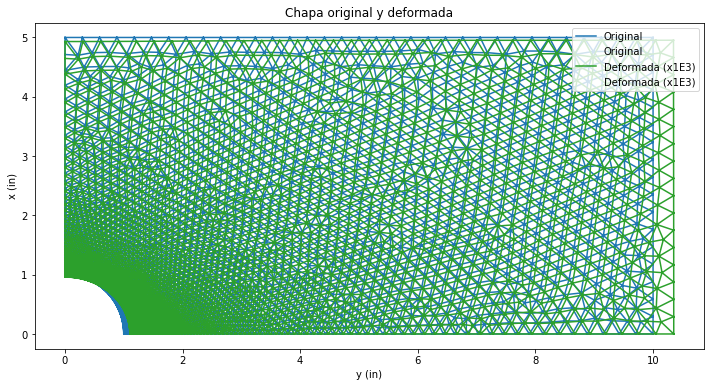

In [26]:
MN_f = MN+d_xyz*1E3 #agrego una escala al desplazamiento para que se pueda apreciar en el grafico
fig, ax = plt.subplots(figsize=(12,6))
plt.triplot(MN[:,0], MN[:,1], MC, label='Original')
plt.triplot(MN_f[:,0], MN_f[:,1], MC, label='Deformada (x1E3)')
plt.legend()
plt.title('Chapa original y deformada')
plt.ylabel('x (in)')
plt.xlabel('y (in)')

#### Grafico de las fuerzas

Text(0, 0.5, 'y (in)')

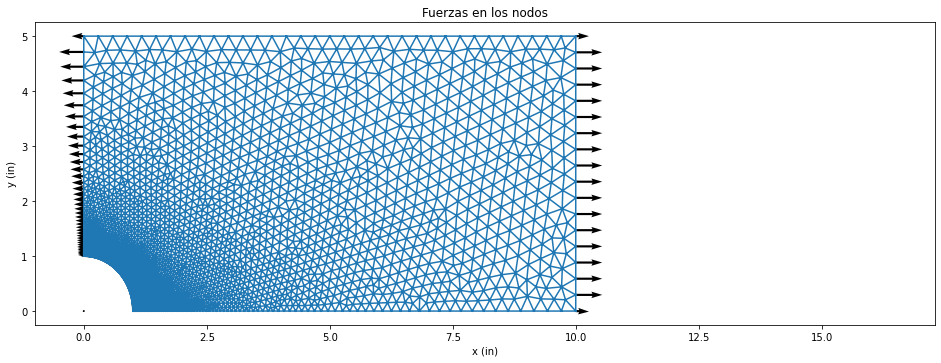

In [27]:
# Obtengo componentes x e y de las fuerzas
Fx = F[2*np.arange(n_nodos)]
Fy = F[2*np.arange(n_nodos)+1]

# Grafico
fig = plt.figure(figsize=(25,7))
ax = fig.add_axes([0.1, 0.2, 0.5, 0.6])
#ax.triplot(MN[:,0],MN[:,1])
ax.triplot(MN[:,0], MN[:,1], MC)
#mdfcomment ax.quiver( MN[:,0], MN[:,1], Fx, Fy, linewidth=5, units='width', scale=1e5)   # Flechas
ax.quiver( MN[:,0], MN[:,1], Fx, Fy, linewidth=5, units='width', scale=1e4)   # Flechas
ax.set_xlim(-1, 0.85*L+(Fx/1e3).max())
plt.title('Fuerzas en los nodos')
ax.set_xlabel('x (in)')
ax.set_ylabel('y (in)')

#### Grafico de los desplazamientos

Text(0, 0.5, 'y (in)')

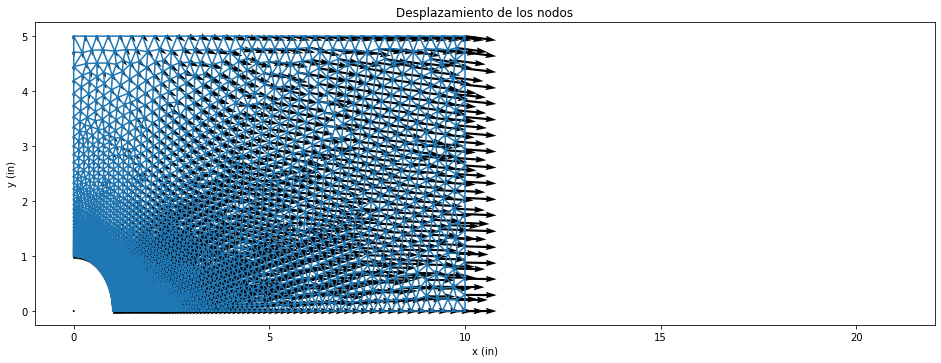

In [28]:
# Obtengo componentes x e y de los desplazamientos
Ux = U[2*np.arange(n_nodos)]
Uy = U[2*np.arange(n_nodos)+1]

# Grafico
fig = plt.figure(figsize=(25,7))
ax = fig.add_axes([0.1, 0.2, 0.5, 0.6])
ax.triplot(MN[:,0],MN[:,1],MC-MC.min(), )
ax.quiver( MN[:,0], MN[:,1], Ux*1e7, Uy*1e7, linewidth=5, units='width', scale=1e5)   # Flechas
ax.set_xlim(-1, 1.1*L+(Ux).max())
plt.title('Desplazamiento de los nodos')
ax.set_xlabel('x (in)')
ax.set_ylabel('y (in)')

### Vista en GMSH

In [29]:
# Desplazamientos
desps = gmsh.view.add("Desplazamientos")
Desps = gmsh.view.addModelData(desps, 0, 'Ej 2', 'NodeData', NodeInfo[0], d_xyz, numComponents=3)
gmsh.option.setNumber(f'View[{desps}].VectorType', 5)

# Fuerzas
Fxy = F.reshape(n_nodos, glxn)
Fxyz = np.append(Fxy, np.zeros(Fxy.shape[0]).reshape([-1, 1]), 1)
fuerzas = gmsh.view.add('Fuerzas')
Fuerzas = gmsh.view.addModelData(fuerzas, 0, 'Ej 2', 'NodeData', NodeInfo[0], Fxyz, numComponents=3)
gmsh.option.setNumber(f'View[{fuerzas}].VectorType', 4)
gmsh.option.setNumber(f'View[{fuerzas}].GlyphLocation', 2)

# Tensiones
sig_xytau = np.hstack(list(sigma.values()))
sigx = gmsh.view.add('Tensiones en x')
sigy = gmsh.view.add('Tensiones en y')
sigxy = gmsh.view.add('Tensiones xy')
SIGX = gmsh.view.addModelData(sigx, 0, 'Ej 2', 'ElementData', E_etiq, sig_xytau[0,:].reshape([-1,1]), numComponents=1)
SIGY = gmsh.view.addModelData(sigy, 0, 'Ej 2', 'ElementData', E_etiq, sig_xytau[1,:].reshape([-1,1]), numComponents=1)

#Actualizo y grafico
gmsh.model.geo.synchronize()
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.10.5
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20220701
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.4.0
PETSc version : 3.14.4 (real arithmtic)
OCC version   : 7.6.1
MED version   : 4.1.0
Packaged by   : geuzaine
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


<div style="background:#999900"> y ya que estamos: </div>

In [32]:
MC.shape

(6051, 3)

Text(0, 0.5, 'y (in)')

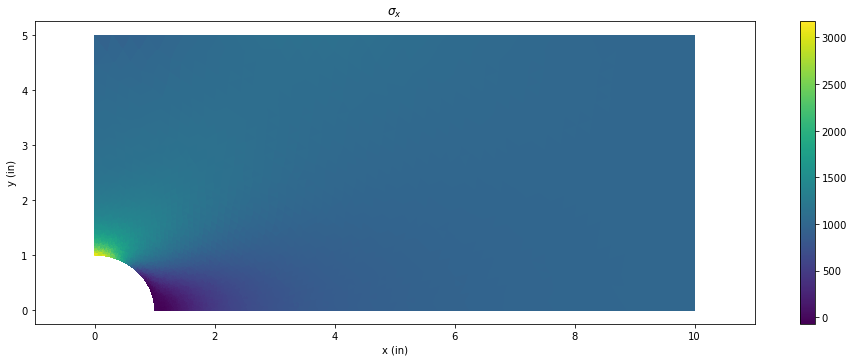

In [38]:
# Obtengo componentes x e y de los desplazamientos
# Grafico
fig = plt.figure(figsize=(25,7))
ax = fig.add_axes([0.1, 0.2, 0.5, 0.6])
mappable = ax.tripcolor(MN[:,0], MN[:,1],MC, facecolors=sig_xytau[0])
cbar = plt.colorbar(mappable)
ax.set_xlim(-1, 1.1*L/2)
plt.title(r'$\sigma_x$')
ax.set_xlabel('x (in)')
ax.set_ylabel('y (in)')

Text(0, 0.5, 'y (in)')

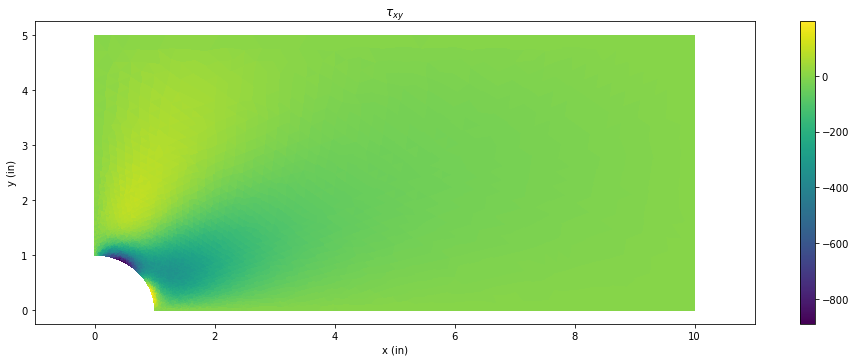

In [36]:
# Obtengo componentes x e y de los desplazamientos
# Grafico
fig = plt.figure(figsize=(25,7))
ax = fig.add_axes([0.1, 0.2, 0.5, 0.6])
mappable = ax.tripcolor(MN[:,0], MN[:,1],MC, facecolors=sig_xytau[2])
cbar = plt.colorbar(mappable)
ax.set_xlim(-1, 1.1*L/2)
plt.title(r'$\tau_{xy}$')
ax.set_xlabel('x (in)')
ax.set_ylabel('y (in)')